### Get in touch with segyio and xarray, plot the angle stacks, well and horizon from Avseth et al. (2010)

Learning from Alessandro del Monte - [Playing with seismic](https://github.com/aadm/geophysical_notes/blob/master/playing_with_seismic.ipynb), [Seismic amplitude extraction](https://github.com/aadm/geophysical_notes/blob/master/seismic_amplitude_extraction.ipynb), [AVO projections](https://github.com/aadm/geophysical_notes/blob/master/avo_projections.ipynb) and [Top Heimdal map](https://github.com/aadm/geophysical_notes/blob/master/top_heimdal_map.ipynb).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import segyio
import xarray as xr

%matplotlib inline

Read the data and get infos

In [2]:
def read_segy(f ,byte_il=189, byte_xl=193):
    with segyio.open(f, iline=byte_il, xline=byte_xl) as segyfile:
        sr = segyio.tools.dt(segyfile)/1e3 #sample rate
        nsamples = segyfile.samples.size
        twt = segyfile.samples + 1500
        ntraces = segyfile.tracecount
        data = segyio.tools.cube(segyfile)
        header = segyio.tools.wrap(segyfile.text[0])  
        inlines = segyfile.ilines/1000
        crosslines = segyfile.xlines
    size_mb= data.nbytes/1024**2
    print('[read_segy] number of traces: {0}, samples: {1}, sample rate: {2} s'.format(ntraces,nsamples,sr))
    print('[read_segy] first, last sample twt: {0}, {1} s'.format(twt[0],twt[-1]))
    print('[read_segy] size: {:.2f} Mb ({:.2f} Gb)'.format(size_mb, size_mb/1024))
    print('[read_segy] inlines: {:.0f}, min={:.0f}, max={:.0f}'.format(inlines.size,inlines.min(),inlines.max()))
    print('[read_segy] crosslines: {:.0f}, min={:.0f}, max={:.0f}'.format(crosslines.size,crosslines.min(),crosslines.max()))

    return (data, nsamples, sr, twt, ntraces, header, inlines, crosslines)

Import well 2

In [3]:
w2=np.recfromcsv('qsiwell2.csv',names=True)
w2z=w2['depth']
w2vp=w2['vp']/1e3
w2vs=w2['vs']/1e3
w2vpvs=w2['vpvs']
w2rho=w2['rho']
w2phi=w2['nphi']

well2_il, well2_xl = 1376, 1776

tops_w2={'Heimdal': 2153,'OWC': 2183}

Plot the well

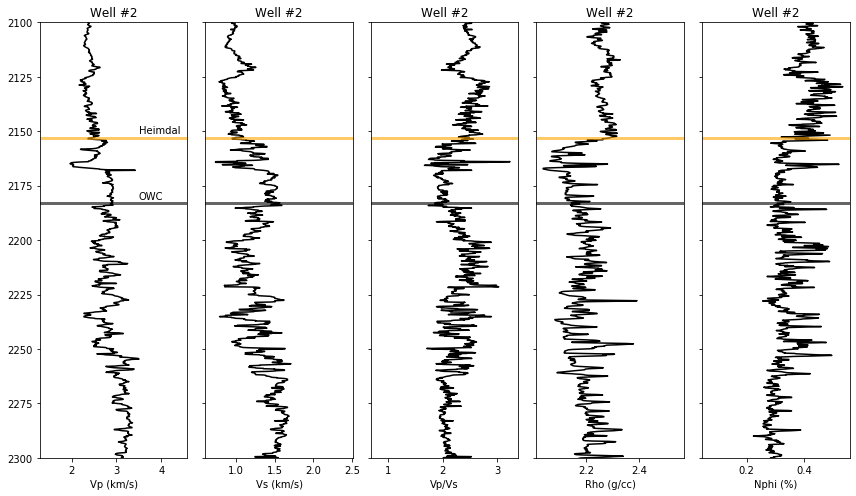

In [4]:
log = [w2vp, w2vs, w2vpvs, w2rho, w2phi]
unit = ['Vp (km/s)', 'Vs (km/s)', 'Vp/Vs', 'Rho (g/cc)', 'Nphi (%)']

f, ax = plt.subplots(nrows=1,ncols=5,figsize=(12,7))
for i in range(len(log)):
    ax[i].plot(log[i],w2z,'-k')
    ax[i].set_title('Well #2')
    ax[i].axhline(y=float(tops_w2['Heimdal']),color='orange',lw=3,alpha=0.6)
    ax[i].axhline(y=float(tops_w2['OWC']),color='black',lw=3,alpha=0.6)
    ax[i].set_xlabel(unit[i])
    ax[i].set_ylim(2300,2100)
    if i == 0:
        ax[i].text(3.5,tops_w2['Heimdal']-2,'Heimdal')
        ax[i].text(3.5,tops_w2['OWC']-2,'OWC')
    else:
        ax[i].set_yticklabels([])
        
plt.tight_layout()

Import the data

In [5]:
data_n, nsamples, sr, twt, ntraces, header, inlines, crosslines = read_segy('3d_nearstack.sgy',byte_il=41,byte_xl=21)
near = xr.DataArray(data_n,[('IL',inlines),('XL',crosslines),('TWT',twt)])

[read_segy] number of traces: 25351, samples: 250, sample rate: 4.0 s
[read_segy] first, last sample twt: 1500.0, 2496.0 s
[read_segy] size: 24.18 Mb (0.02 Gb)
[read_segy] inlines: 101, min=1300, max=1500
[read_segy] crosslines: 251, min=1500, max=2000


In [6]:
data_f, *_ = read_segy('3d_farstack.sgy',byte_il=41,byte_xl=21)
far = xr.DataArray(data_f,[('IL',inlines),('XL',crosslines),('TWT',twt)])

[read_segy] number of traces: 25351, samples: 250, sample rate: 4.0 s
[read_segy] first, last sample twt: 1500.0, 2496.0 s
[read_segy] size: 24.18 Mb (0.02 Gb)
[read_segy] inlines: 101, min=1300, max=1500
[read_segy] crosslines: 251, min=1500, max=2000


Import the horizon

In [7]:
hrz=np.recfromtxt('Top_Heimdal_subset.txt', names=['il','xl','z'])

#### Plot Near and Far stack

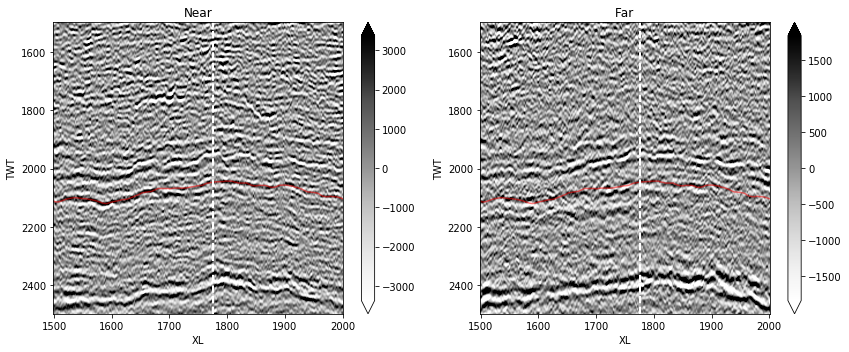

In [8]:
inline=1376
uu={'robust':True,'interpolation':'spline16','cmap':'Greys'}

f, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
near.sel(IL=1376).plot.imshow(x='XL',y='TWT',yincrease=False,ax=ax[0],**uu)
ax[0].plot(hrz[hrz['il']==inline]['xl'],hrz[hrz['il']==inline]['z'],color='r',alpha=0.5,label='Top Heimdal')
ax[0].axvline(well2_xl,color='w',ls='--',lw=2)
ax[0].set_title('Near')

far.sel(IL=1376).plot.imshow(x='XL',y='TWT',yincrease=False,ax=ax[1],**uu)
ax[1].plot(hrz[hrz['il']==inline]['xl'],hrz[hrz['il']==inline]['z'],color='r',alpha=0.5,label='Top Heimdal')
ax[1].axvline(well2_xl,color='w',ls='--',lw=2)
ax[1].set_title('Far'),

plt.tight_layout()

#### Plot Near stack

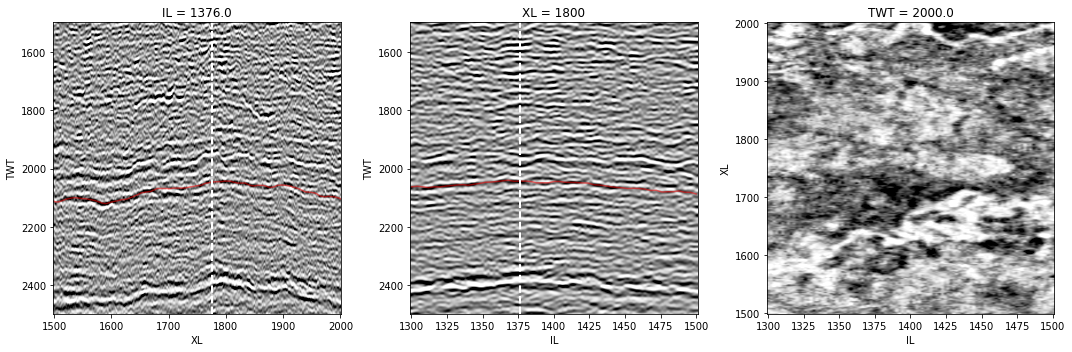

In [9]:
inline=1376
xline=1800
uu={'add_colorbar':False,'robust':True,'interpolation':'spline16','cmap':'Greys'}

f, ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
near.sel(IL=1376).plot.imshow(x='XL',y='TWT',yincrease=False,ax=ax[0],**uu)
ax[0].plot(hrz[hrz['il']==inline]['xl'],hrz[hrz['il']==inline]['z'],color='r',alpha=0.5,label='Top Heimdal')
ax[0].axvline(well2_xl,color='w',ls='--',lw=2)

near.sel(XL=1800).plot.imshow(x='IL',y='TWT',yincrease=False,ax=ax[1],**uu)
ax[1].plot(hrz[hrz['xl']==xline]['il'],hrz[hrz['xl']==xline]['z'],color='r',alpha=0.5,label='Top Heimdal')
ax[1].axvline(well2_il,color='w',ls='--',lw=2)

near.sel(TWT=2000).plot.imshow(x='IL',y='XL',ax=ax[2],**uu)
plt.tight_layout()

#### Plot Far stack

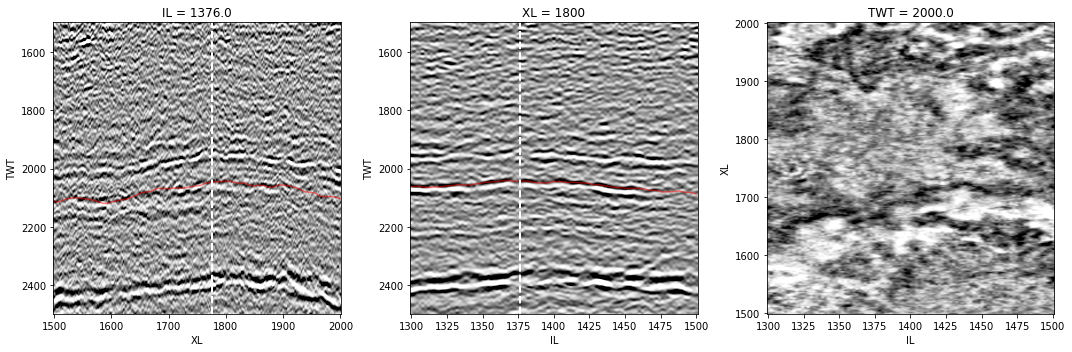

In [10]:
inline=1376
xline=1800
uu={'add_colorbar':False,'robust':True,'interpolation':'spline16','cmap':'Greys'}

f, ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
far.sel(IL=1376).plot.imshow(x='XL',y='TWT',yincrease=False,ax=ax[0],**uu)
ax[0].plot(hrz[hrz['il']==inline]['xl'],hrz[hrz['il']==inline]['z'],color='r',alpha=0.5,label='Top Heimdal')
ax[0].axvline(well2_xl,color='w',ls='--',lw=2)

far.sel(XL=1800).plot.imshow(x='IL',y='TWT',yincrease=False,ax=ax[1],**uu)
ax[1].plot(hrz[hrz['xl']==xline]['il'],hrz[hrz['xl']==xline]['z'],color='r',alpha=0.5,label='Top Heimdal')
ax[1].axvline(well2_il,color='w',ls='--',lw=2)

far.sel(TWT=2000).plot.imshow(x='IL',y='XL',ax=ax[2],**uu)
plt.tight_layout()

## References

Alessandro del Monte - Playing with seismic https://github.com/aadm/geophysical_notes/blob/master/playing_with_seismic.ipynb

Alessandro del Monte - Seismic amplitude extraction https://github.com/aadm/geophysical_notes/blob/master/seismic_amplitude_extraction.ipynb

Alessandro del Monte - AVO projections https://github.com/aadm/geophysical_notes/blob/master/avo_projections.ipynb

Alessandro del Monte - Top Heimdal map https://github.com/aadm/geophysical_notes/blob/master/top_heimdal_map.ipynb

Avseth, P., Mukerji, T., & Mavko, G., 2010. Quantitative seismic interpretation: Applying rock physics tools to reduce interpretation risk. Cambridge university press.

The dataset: https://srb.stanford.edu/quantitative-seismic-interpretation